## Comparing GNN Approaches in Molecule Identification

In [3]:
!pip install tensorflow==2.14.0

  Using cached tensorflow-2.14.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
Using cached tensorflow-2.14.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (489.8 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.14.0 which is incompatible.


In [5]:
import tensorflow as tf
print(tf.__version__)

2.14.0


In [6]:
pip install spektral

In [7]:
pip install rdkit

Firstly, we will show how original data downloaded from CompTox database via scrapping tehnique is converted into graph format

In [8]:
from rdkit import Chem
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit import Chem, DataStructs
from sklearn.preprocessing import OneHotEncoder
from spektral.data import Graph, Dataset
import numpy as np
import os
import h5py
import random

Cloning github repository where the original data is

In [9]:
!git clone https://github.com/ivanna1109/DSC_Conference2024Materials

fatal: destination path 'DSC_Conference2024Materials' already exists and is not an empty directory.


In [10]:
assays = [
    "ATG_PPARg_TRANS_dn",
    "ATG_PPARg_TRANS_up",
    "TOX21_PPARg_BLA_antagonist_ratio",
    "TOX21_PPARg_BLA_Agonist_ratio",
    "NVS_NR_hPPARg",
    "ERF_ENZ_hCYP19A1_dn",
    "NVS_ADME_hCYP19A1",
    "NVS_ADME_hCYP19A1_Activator",
    "TOX21_Aromatase_Inhibition",
    "CEETOX_H295R_ESTRADIOL_dn",
    "CEETOX_H295R_ESTRADIOL_noMTC_dn",
    "CEETOX_H295R_ESTRADIOL_noMTC_up",
    "CEETOX_H295R_ESTRADIOL_up",
    "CEETOX_H295R_ESTRONE_dn",
    "CEETOX_H295R_ESTRONE_noMTC_dn",
    "CEETOX_H295R_ESTRONE_noMTC_up",
    "CEETOX_H295R_ESTRONE_up"
]

effects = [
    "dn",
    "up",
    "dn",
    "up",
    "dn",
    "dn",
    "dn",
    "up",
    "dn",
    "dn",
    "dn",
    "up",
    "up",
    "dn",
    "dn",
    "up",
    "up"
]

This code processes data on various biochemical tests (assays) and their results, combining them into several DataFrames. It also prepares data on SMILES strings (representations of molecules) and removes duplicates. In the end, we obtain a list of DataFrames (dfs) and a consolidated DataFrame with SMILES data (smiles).

In [11]:
# find all matching

dfs = []
smiles = []

for assay, effect in zip(assays, effects):
    path = f"DSC_Conference2024Materials/data/{assay}.csv"
    df = pd.read_csv(path)
    # print(df["smiles"].isnull().sum())

    s = df[["preferredName", "smiles"]].copy()
    s.index = s["preferredName"]
    del s["preferredName"]
    smiles.append(s)

    df = df[["preferredName", "hitc"]] # only leave these two columns

    df = df[df["hitc"] != -1] # 22.9.2022.: remove inconclusive results

    df[f"effect_{assay}"] = -1 if effect == "dn" else 1

    df["hitc"] *= df[f"effect_{assay}"]

    del df[f"effect_{assay}"]

    df.index = df["preferredName"]
    del df["preferredName"] # set index to name and remove the column name
    df.columns = [assay] # set type (only remaining column) to name of assay

    dfs.append(df)

# save for later
smiles = pd.concat(smiles, axis=0)
smiles = smiles[~smiles.index.duplicated(keep='first')]

In [12]:
smiles.isnull().sum() # should be zero, all smiles are fixed

,0
smiles,0


In [13]:
dfs[12].value_counts() #example of one csv file in dataset

,count
CEETOX_H295R_ESTRADIOL_up,
0,514
1,58


Method for converting smiles representation of molecule into graph structure

In [14]:

def smiles_to_graph(smiles_str, label):
    mol = Chem.MolFromSmiles(smiles_str)
    label_type = {
        0: 'inactive',
        1: 'partially active',
        2: 'active'
    }
    G = nx.Graph(label=label_type.get(label, -1))

    bond_type_mapping = {
        Chem.BondType.SINGLE: 1,
        Chem.BondType.DOUBLE: 2,
        Chem.BondType.TRIPLE: 3,
        Chem.BondType.AROMATIC: 4
    }

    for atom in mol.GetAtoms():
        atom_idx = atom.GetIdx()
        atom_symbol = atom.GetSymbol()
        #print(f"Simbol atoma {atom_symbol}")
        atom_degree = atom.GetDegree()
        G.add_node(atom_idx, atom_label=str(atom_symbol), degree=atom_degree)

    for bond in mol.GetBonds():
        bond_type = bond.GetBondType()
        encoded_bond_type = bond_type_mapping.get(bond_type, 0)
        G.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), weight=encoded_bond_type, bond_type=encoded_bond_type)

    return G

In [15]:
graphs_list = list()
bad_smiles = []

In [16]:
def get_graph(row):
    print("Processing row:", row)
    try:
        molecule_label = 'active'
        if row.label == 0: molecule_label = 'inactive'
        elif row.label == 1: molecule_label = 'partially_active'
        sm = smiles.loc[row.name, 'smiles']
        print(f"SMILES for {row.name} which is {molecule_label}: {sm}")

        if pd.isna(sm):
            raise ValueError("SMILES string is NaN")
        graph = smiles_to_graph(sm, row.label)
        graphs_list.append(graph)
        return graph
        """ all molecules are saved into separate gml files
        gml_file = f"molecules/molecule_{row.name}_{row.label}.gml"
        nx.write_gml(graph_smile, gml_file)
        print(f"Graf za {sm} sačuvan je u {gml_file}")
        """
    except Exception as e:
        print(f"Bad smiles string for {row.name}: {e}")
        bad_smiles.append(row.name)

Visualization of one molecule graph

In [17]:
def visualize_graph(G):
    plt.figure(figsize=(12, 6))
    pos = nx.spring_layout(G)

    nx.draw_networkx(G, pos, with_labels=False, node_color='lightblue', node_size=500, edge_color='gray')

    node_labels = nx.get_node_attributes(G, 'atom_label')
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12, font_color='black')

    edge_labels = nx.get_edge_attributes(G, 'bond_type')
    edge_labels_str = {
        (u, v): {1: "S", 2: "D", 3: "T", 4: "A"}.get(edge_labels[(u, v)], "Unknown")
        for u, v in edge_labels
    }
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels_str, font_color='red')

    graph_label = G.graph.get('label', 'No Label')
    plt.text(0.5, 1.05, f"Label: {graph_label}", fontsize=15, ha='center', transform=plt.gca().transAxes)

    plt.show()

<ipython-input-18-63c45b11a8d8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assay["label"] = np.where(assay["label"] == 1, 2, assay["label"]) # up
<ipython-input-18-63c45b11a8d8>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assay["label"] = np.where(assay["label"] == -1, 1, assay["label"]) # dn
<ipython-input-18-63c45b11a8d8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

label
0.0    21095
2.0     1320
1.0     1066
Name: count, dtype: int64
label
0.0    7306
1.0    1302
2.0       3
Name: count, dtype: int64
Processing row: label    1.0
Name: Tetrahydrocurcumin, dtype: float64
SMILES for Tetrahydrocurcumin which is partially_active: COC1=CC(CCC(=O)CC(=O)CCC2=CC(OC)=C(O)C=C2)=CC=C1O


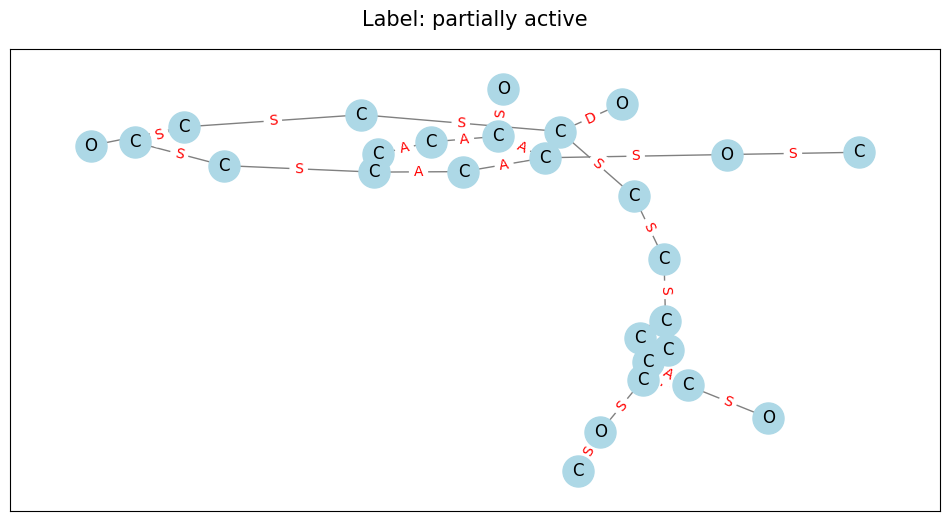

ok: 1
bad: []
bad count: 0


In [18]:
plt_count = 1
for assay, name in zip([pd.concat(dfs[0:5]), pd.concat(dfs[5:9]), pd.concat(dfs[9:17])],
                       ["ke1", "ke2", "ke3"]):

    assay["label"] = assay.sum(axis=1)

    assay = assay[["label"]]

    assay["label"] = np.where(assay["label"] == 1, 2, assay["label"]) # up
    assay["label"] = np.where(assay["label"] == -1, 1, assay["label"]) # dn

    print(assay["label"].value_counts())

    #assay.apply(lambda mol: get_graph(mol), axis=1)
    molecule = assay.iloc[0]  # Take only one molecule for demonstration
    if molecule.label == 1:
        graph = get_graph(molecule)
        visualize_graph(graph)

        print("ok:", len(graphs_list))
        print("bad:", bad_smiles)
        print("bad count:", len(bad_smiles))
        break

Since we lack rich nodes features, we will generate some initial ones, using DeepWalk and Word2Vec techniques

In [19]:
def generate_random_walk(start_node, walk_length, graph): #geenrate one walk for molecule graph
    walk_sequence = [str(start_node)]

    for _ in range(walk_length):
        neighbors = list(graph.neighbors(start_node))
        if not neighbors:
            break  # If node does not have neighbors, stop the walk
        next_node = np.random.choice(neighbors)
        walk_sequence.append(str(next_node))
        start_node = next_node

    return walk_sequence

In [20]:
def generate_random_walks(graph, num_walks, walk_length):
    walks = []

    for _ in range(num_walks):
        # Random choose starting node
        start_node = np.random.choice(list(graph.nodes()))
        # Generate one walk
        walk = generate_random_walk(start_node, walk_length, graph)
        walks.append(walk)

    return walks

In [21]:
from gensim.models import Word2Vec

In [22]:
def deepwalk_embedding(graphs, dimensions=64):
    walks = []
    for G in graphs:
        walks.extend(list(generate_random_walks(G, num_walks=150, walk_length=35)))

    model = Word2Vec(sentences=walks, vector_size=dimensions, window=5, min_count=0, sg=1, workers=4)
    embeddings = [np.array([model.wv[str(node)] for node in G.nodes()]) for G in graphs]
    return embeddings

In [23]:
# 2. Add one-hot encoded atomic labels to node embeddings
def add_element_features(graphs, embeddings, element_index):
    X_with_elements = []
    for G, embedding in zip(graphs, embeddings):
        element_features = np.zeros((len(G.nodes()), len(element_index)))
        for i, node in enumerate(G.nodes()):
            element = G.nodes[node].get('atom_type', '*')
            if element in element_index:
                element_features[i, element_index[element]] = 1
        combined_features = np.hstack([embedding, element_features])
        X_with_elements.append(combined_features)
    return X_with_elements

In [24]:

elements = ['O', 'C', 'Au', 'Yb', 'Ba', 'Mo', 'Pd', 'Hg',
            'H', 'Nd', 'Dy', 'Se', 'Co', 'Li', 'Br', 'Bi', 'Cr', 'Ge',
              'Ag', 'Mg', 'Zr', 'Pt', 'Be', 'Ni', 'Cl', 'Gd', 'Sc', 'Tl',
              'Zn', 'P', 'K', 'N', 'As', 'Ti', 'Sr', 'Sn', 'Na', 'Cd',
              'Al', 'Cu', 'Si', 'F', 'Eu', 'Pb', 'Sb', 'V', 'S', 'Fe', 'B',
              'I', 'Ca', 'In', 'Mn']  # This is all possible chemical elements that could occur in any molecule
element_index = {elem: idx for idx, elem in enumerate(elements)}
classes = {'inactive':0, 'partially active':1, 'active':2}
nx_graphs = []
labels = []
adj_matrixs = []

When we read graph from GML file, we extract information like adjacency matrix and label, and then do data augmentation using graph isomorphism for graphs that belonge to the minority class of activity (like partially active and active), it is some kind of oversampling using replication of the graph with modified adjacency matrix

In [25]:
gml_file ='DSC_Conference2024Materials/molecule_example/molecule_Tetrahydrocurcumin_1.0.gml'

In [26]:
def generate_graphs(gml_file, nx_graphs, labels, adj_matrixs):
    G = nx.read_gml(gml_file)
    G.graph['molecule_name'] = os.path.basename(gml_file)[9:-8]
    print("Graph loaded from folder")
    if all(deg >= 1 for node, deg in G.degree()):
        nx_graphs.append(G)
        labels.append(classes.get(G.graph.get('label')))
        original_matrix = nx.adjacency_matrix(G).toarray()
        adj_matrixs.append(original_matrix)
        if (G.graph.get('label')=='active' or G.graph.get('label')=='partially active'):
            range_gr = 4
            if (G.graph.get('label')=='active'): range_gr = 5
            for i in range(range_gr):
                nodes = list(G.nodes)
                random.shuffle(nodes)
                mapping = {old_label: new_label for old_label, new_label in zip(G.nodes, nodes)}
                G_iso = nx.relabel_nodes(G, mapping)
                sorted_nodes = sorted(mapping.keys(), key=lambda x: mapping[x])
                sorted_indices = [list(G.nodes).index(node) for node in sorted_nodes]
                isomorphic_am = nx.adjacency_matrix(G_iso).toarray()
                A_sorted = isomorphic_am[np.ix_(sorted_indices, sorted_indices)]
                new_G_iso = nx.from_numpy_array(A_sorted)
                node_labels = nx.get_node_attributes(G_iso, 'atom_label')

                inverse_mapping = {v: k for k, v in mapping.items()}
                for idx, node in enumerate(sorted_indices):
                    #print(node_labels[str(node)])
                    new_G_iso.nodes[node]['atom_label'] = node_labels[str(node)]
                new_G_iso.graph['molecule_name'] = G.graph['molecule_name']
                nx_graphs.append(new_G_iso)
                labels.append(classes.get(G.graph.get('label')))
                adj_matrixs.append(A_sorted)
    print("Generated ismorphics graphs")


In [27]:
generate_graphs(gml_file, nx_graphs, labels, adj_matrixs)


Graph loaded from folder
Generated ismorphics graphs


In [28]:
X_embeddings = deepwalk_embedding(nx_graphs)

X_embeddings_with_elements = add_element_features(nx_graphs, X_embeddings, element_index)

In [62]:
print(type(nx_graphs[0]))

<class 'networkx.classes.graph.Graph'>


After we created node features embedding (aka graph embedding), we store them together with adjacency matrix, graph label (level of activity) and name of molecule into h5 file

In [29]:
num_of_g = 0
file_path = 'DSC_Conference2024Materials/graph_dataset/molecule_datasetAugmented.h5'
with h5py.File(file_path, 'w') as f:
    for i, graph in enumerate(nx_graphs):
        grp = f.create_group(f'graph_{i}')
        grp.create_dataset('x', data=X_embeddings_with_elements[i])
        grp.create_dataset('a', data=adj_matrixs[i])
        if num_of_g == 0:
          print("Example of nodes feature vector: \n", X_embeddings_with_elements[i])
          print("Shape of nodes feature vector: ", X_embeddings_with_elements[i].shape)
          print("Example of adjacency matrix: \n", adj_matrixs[i])
          print("Shape of adjacency matrix:", adj_matrixs[i].shape)
          print("-"*56)
        grp.create_dataset('y', data=labels[i])

        grp.attrs['molecule_name'] = graph.graph.get('molecule_name')
        num_of_g+=1

print("Total number of saved graphs: ", num_of_g)

Example of nodes feature vector: 
 [[-0.17936368  0.31328335  0.21906547 ...  0.          0.
   0.        ]
 [ 0.46021202  0.07413845  0.42520922 ...  0.          0.
   0.        ]
 [ 0.09957044  0.00555571  0.36241835 ...  0.          0.
   0.        ]
 ...
 [ 0.23128757 -0.1022665   0.34827787 ...  0.          0.
   0.        ]
 [ 0.20856592 -0.15053061  0.40453929 ...  0.          0.
   0.        ]
 [ 0.30629566  0.1181232   0.1962412  ...  0.          0.
   0.        ]]
Shape of nodes feature vector:  (27, 117)
Example of adjacency matrix: 
 [[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0]
 [0 0 4 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 4 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0]
 [0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0

When we read the previous saved file, we create Spektral Dataset of Spektral Graphs which we will use as input for our GNNs

In [30]:
def create_graph_spectral(x, a, m_name):
    return Graph(x=x, a=a, molecule_name=m_name)

class MolecularDataset(Dataset):
    def __init__(self, file_path, **kwargs):
        self.file_path = file_path
        super().__init__(**kwargs)

    def read(self):
        graphs = []
        labels = []
        with h5py.File(self.file_path, 'r') as f:
            for i in range(len(f.keys())):
                grp = f[f'graph_{i}']

                x = grp['x'][:] #list of node features
                a = grp['a'][:] #adjacency matrix
                m_name = grp.attrs['molecule_name']
                y_label = grp['y'][()]#label (numeric)
                graph = create_graph_spectral(x, a, m_name)
                graphs.append(graph)
                labels.append(y_label)

        return graphs, labels

In [31]:

def read_molecule_data(filename):
    dataset = MolecularDataset(filename)
    graphs, labels = dataset.read()
    return graphs, labels

In [32]:
g, l = read_molecule_data(file_path)

/usr/local/lib/python3.10/dist-packages/spektral/data/dataset.py:120: UserWarning: The graphs in this dataset have no adjacency matrix. Is this intentional?
  warnings.warn(


In [33]:
print(type(g[i])) #Spektral Graph
print(g[i].x.shape) #shape of graph embedding
print(l[i]) #numeric label (0:active, 1:partially active, 2: active)

<class 'spektral.data.graph.Graph'>
(27, 117)
1


Now we will show the architectures of two of our four models (spektral and tensorflow layers are used)

In [34]:
import tensorflow as tf
from spektral.layers import GCNConv, GlobalMaxPool, GraphSageConv, GlobalAvgPool, GlobalMaxPool
from tensorflow.keras.layers import Dense, Dropout,  BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from spektral.data import DisjointLoader

In [35]:
class GCN(Model):
    def __init__(self, num_features, num_labels, hidden_units, dense_units, dropout_rate):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(hidden_units, activation='relu')
        self.conv2 = GCNConv(hidden_units, activation='relu')
        self.conv3 = GCNConv(hidden_units, activation='relu')
        self.global_pool = GlobalMaxPool()

        self.dropout2 = Dropout(dropout_rate)
        self.dense1 = Dense(dense_units[0], activation='relu',
                            kernel_regularizer=tf.keras.regularizers.l2(0.01))

        self.dense2 = Dense(dense_units[1], activation='relu',
                            kernel_regularizer=tf.keras.regularizers.l2(0.01))

        self.output_layer = Dense(num_labels, activation='softmax')

    def call(self, inputs, training=False):
        x, a = inputs
        x = self.conv1([x, a])
        x = self.dropout2(x, training=training)

        x = self.conv2([x, a])
        x = self.conv3([x, a])
        x = tf.reduce_mean(x, axis=1)
        x = self.dense1(x)
        x = self.dense2(x)
        output = self.output_layer(x)

        return output

In [36]:
class GraphSageModel(Model):
    def __init__(self, num_node_features, num_classes, hidden_units, dense_units, dropout_rate, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = GraphSageConv(hidden_units, agregate='mean', activation='relu')
        self.bn1 = BatchNormalization()
        self.dropout1 = Dropout(dropout_rate)

        self.conv2 = GraphSageConv(hidden_units, agregate='mean', activation='relu')
        self.bn2 = BatchNormalization()
        self.conv3 = GraphSageConv(hidden_units, agregate='mean', activation='relu')
        self.bn3 = BatchNormalization()

        self.pool = GlobalAvgPool()
        self.flatten = tf.keras.layers.Flatten()
        self.dropout2= Dropout(dropout_rate)
        self.dense1 = Dense(dense_units[0], activation='relu')
        self.dense2 = Dense(dense_units[1], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.output_layer = Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        print(len(inputs))
        x, sparse_a, i = inputs
        x = self.conv1([x, sparse_a])
        x = self.bn1(x, training=training)
        x = self.dropout1(x, training=training)

        x = self.conv2([x, sparse_a])
        x = self.bn2(x, training=training)
        x = self.conv3([x, sparse_a])
        x = self.bn3(x, training=training)
        x = self.pool([x, i])
        x = self.flatten(x)
        x = self.dropout2(x, training=training)
        x = self.dense1(x)
        x = self.dense2(x)
        output = self.output_layer(x)
        return output



Below is an example of data preparation for GraphSage model training

In [37]:
X_train, X_test, y_train, y_test = train_test_split(g, l, test_size=0.2, random_state=42, stratify=labels)
print("Data is splited into train and test. (80:20), same for validation.")

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify = y_train)
print(f"Num instances in x_train {len(X_train)}")
print(f"Num of instances in x_val {len(X_val)}")
print(f"Num of instances in x_test {len(X_test)}")


Data is splited into train and test. (80:20), same for validation.
Num instances in x_train 3
Num of instances in x_val 1
Num of instances in x_test 1


In [38]:
# Convert labels into one-hot format
num_labels =3
y_train = to_categorical(y_train, num_classes=num_labels)
y_val = to_categorical(y_val, num_classes=num_labels)
y_test = to_categorical(y_test, num_classes=num_labels)

In [39]:
print(y_train.shape)

(3, 3)


In [40]:
class MyDataset(Dataset):
    def __init__(self, graphs, labels, **kwargs):
        self.graphs = graphs
        self.labels = labels
        print(f"Loaded {len(self.graphs)} graphs")
        super().__init__(**kwargs)

    def read(self):
        output = []
        for i in range(len(self.graphs)):
            output.append(
            Graph(x=self.graphs[i].x, a=self.graphs[i].a, y=self.labels[i],
                  molecule_name = self.graphs[i].get('molecule_name')))
        return output

In [41]:
print("Creating spektral dataset of splited data...")
train_dataset = MyDataset(X_train, y_train)
val_dataset = MyDataset(X_val, y_val)
test_dataset = MyDataset(X_test, y_test)

Creating spektral dataset of splited data...
Loaded 3 graphs
Loaded 1 graphs
Loaded 1 graphs


Disjoint batch loaders create batches of independent graphs by concatenating their features and adjacency matrices while keeping their structures separate. This is useful for efficiently training on datasets with multiple unrelated graphs, like molecules or networks.

In [42]:
batch_size = 60 #The batch size was set to 60 as calculated by Optuna
train_loader = DisjointLoader(train_dataset, batch_size=batch_size)
val_loader = DisjointLoader(val_dataset, batch_size=batch_size)
test_loader = DisjointLoader(test_dataset, batch_size=batch_size)

In [43]:
num_features = 117  # the number of features per each node
hidden_units = 99  # Number of hidden units in the GraphSAGE layer
dense_units = [93, 241]  # Number of units in the dense (fully connected) layers
dropout_rate = 0.21  # Dropout rate to prevent overfitting


In [44]:
model = GraphSageModel(num_features, num_labels, hidden_units, dense_units, dropout_rate)


Adding various callbacks such as learning rate scheduler, early stopping, and F1 score callback

In [45]:
#custom call back for f1-score
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_f1 = logs.get('val_f1_score')
        if val_f1 is not None:
            print(f'\nEpoch {epoch + 1}: val_f1_score = {val_f1:.4f}')

In [46]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
f1_score_callback = F1ScoreCallback()


In [47]:
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import AUC

def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2 * p * r / (p + r + K.epsilon())
    return K.mean(f1)

In [48]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.00035), #lr po optuna proracunu
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       f1_score,
                       AUC(name='roc_auc', multi_label=True),
                    AUC(curve='PR', name='average_precision')])


In [49]:
import math
from sklearn.utils.class_weight import compute_class_weight

In [50]:
y_train_labels = np.argmax(y_train, axis=1)
print(y_train_labels.shape)

(3,)


Calculates the class weights using the compute_class_weight function with the 'balanced' option, which adjusts the weights inversely proportional to the class frequencies in the training data. It then converts the resulting class weights into a dictionary, where the keys are the class indices, and the values are the corresponding computed weights.

In [51]:

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights_dict = dict(enumerate(class_weights))

train_steps_per_epoch = math.ceil(len(X_train) / batch_size)
val_steps_per_epoch = math.ceil(len(X_val) / batch_size)

Example of code for model train

In [54]:
"""
history = model.fit(
    train_loader,
    validation_data=val_loader,
    epochs = 50,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    class_weight = class_weights_dict,
    callbacks=[lr_scheduler, early_stopping, f1_score_callback]
)
"""

'\nhistory = model.fit(\n    train_loader,\n    validation_data=val_loader,\n    epochs = 50,\n    steps_per_epoch=train_steps_per_epoch,\n    validation_steps=val_steps_per_epoch,\n    class_weight = class_weights_dict,\n    callbacks=[lr_scheduler, early_stopping, f1_score_callback]\n)\n'

# RESULTS

Train and valid loss, accuracy, f1-score, roc-auc and average precision during training

In [61]:
def loss_epoch(history_df, title):
    plt.figure(figsize=(10, 6))

    plt.plot(history_df['loss'], label='Train loss')
    plt.plot(history_df['val_loss'], label='Valid loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss through epochs {title}')
    plt.legend()
    plt.grid()

    plt.show()

In [62]:
def acc_epochs(history_df, title):
    plt.figure(figsize=(10, 6))
    plt.plot(history_df['accuracy'], label='Train accuracy')
    plt.plot(history_df['val_accuracy'], label='Valid accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy through epochs {title}')
    plt.legend()
    plt.grid()
    plt.show()

In [64]:
def f1_score(history, title):
    plt.figure(figsize=(10, 6))
    plt.plot(history['f1_score'], label='F1-score train')
    plt.plot(history['val_f1_score'], label='F1-score valid')
    plt.title('F1-score through epochs {title}')
    plt.xlabel('Epoch')
    plt.ylabel('F1-score')
    plt.legend()
    plt.grid()
    plt.show()

In [65]:
def roc_auc(history, title):
    plt.figure(figsize=(10, 6))
    plt.plot(history['roc_auc'], label='ROC AUC train')
    plt.plot(history['val_roc_auc'], label='ROC AUC valid')
    plt.title(f'ROC AUC through epochs {title}')
    plt.xlabel('Epoch')
    plt.ylabel('ROC AUC')
    plt.legend()
    plt.grid()

    plt.show()

In [66]:
def average_prec_epochs(history_df, title):
    plt.figure(figsize=(10, 6))
    plt.plot(history_df['average_precision'], label='Train average presicion')
    plt.plot(history_df['val_average_precision'], label='Valid average precision')
    plt.xlabel('Epoch')
    plt.ylabel('Average precision')
    plt.title(f'Average precision through epochs {title}')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
train_history_graphSage= pd.read_csv('results/gSage_train_history.csv')